# Digital Dark Field Imaging Tutorial 02 - BFBT grain segmentation, strain, and ordered domains

This notebook demonstrates digital dark field (VDF) mapping of a SPED dataset of a polycrystalline ceramic BiFeO3-BaTiO3 specimen taken together with Dr Shane McCartan.
The following are demonstrated:
1. Segmentation of a single crystal in a ceramic using the diffraction peak list from one position
2. Usage of the segmented crystal image as a binary mask to aid in performing strain mapping for just one crystal
3. Imaging of ordered domain formation using Digital Dark Field images made with arrays of lattice vectors derived from the strain mapping

## Data
This is a real SPED dataset from a sample provided by Ilkan Calisir and David Hall of the University of Manchester and is the same data as is published in 
https://ceramics.onlinelibrary.wiley.com/doi/full/10.1111/jace.17599
You should then set the `filepath` variable in the cell below.

The notebook uses the bragg_peaks in the file at: https://drive.google.com/file/d/1Mw77ABFeHmT9Ba84nIQxyZ9SynGfNSH0/view?usp=drive_link

## Acknowlegements

This notebook was made Ian MacLaren. Contact ian.maclaren@glasgow.ac.uk with any questions.

### Versioning

Last updated on 2025-11-18 with the current dev version of py4DSTEM v.0.14.19.  It is essential that you upgrade to the dev version from this 2025-11-13 onwards or any subsequent numbered release for this to run.  

(e.g. pip install git+https://github.com/py4dstem/py4DSTEM.git#dev --upgrade)

Otherwise, digital_dark_field is missing one function definition for filter_by_position.

In [15]:
# Main 4DSTEM analysis
import py4DSTEM
from py4DSTEM import show
from py4DSTEM.process.diffraction.digital_dark_field import (
    pointlist_to_array,
    aperture_array_generator, 
    DDFimage
)
print(py4DSTEM.__version__)

# Calculations
import numpy as np

# Plotting
import matplotlib.pyplot as plt

0.14.19


# Load raw peak positions and check calibrations

In [2]:
# Note - change the file path to your own local path
filepath = '/local/scratch/Teaching/DDF_example/'

In [3]:
basename = 'BFBTgrain_112'

In [4]:
# minor hack of the filename for saving
filename_braggpeaks = basename+'_bp_lattice.h5'

In [5]:
# Optional reload to pick up previously saved data for reprocessing
bragg_peaks = py4DSTEM.read(
    filepath+filename_braggpeaks, 
    root = '/datacube_root/braggvectors'
)

Reading PointListArray: 100%|██████████| 52851/52851 [00:11<00:00, 4494.05PointList/s]


In [6]:
# Check calibration - should be just 1 and pixels
bragg_peaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:      1
             R_pixel_size:      1
             Q_pixel_units:     pixels
             R_pixel_units:     pixels
             QR_flip:           False
             _root_treepath:    /datacube
             probe_semiangle:   4.941633348699613
             qx0_mean:          128.82901265098036
             qy0_mean:          125.7812167491141
)

# Diffraction pattern centering

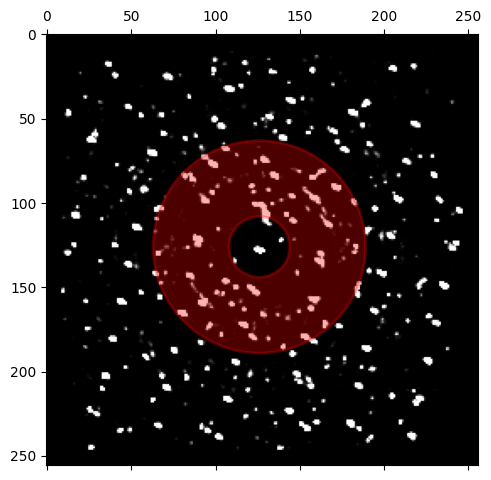

In [8]:
# Guess the center coordinate, specify the radial range for fitting peak pairs
center_guess = (126,126)
radial_range = (18,63)

# Show the ADF detector, overlaid over a new BVM
bragg_vector_map = bragg_peaks.get_bvm(mode='raw')
py4DSTEM.show(
    bragg_vector_map, 
    intensity_range='absolute',
    vmin=0,
    vmax=1000,
    annulus = {
      'center':center_guess,
      'radii' : radial_range,
      'alpha':0.3,
      'fill':True
    },
    figsize=(5,5)
)

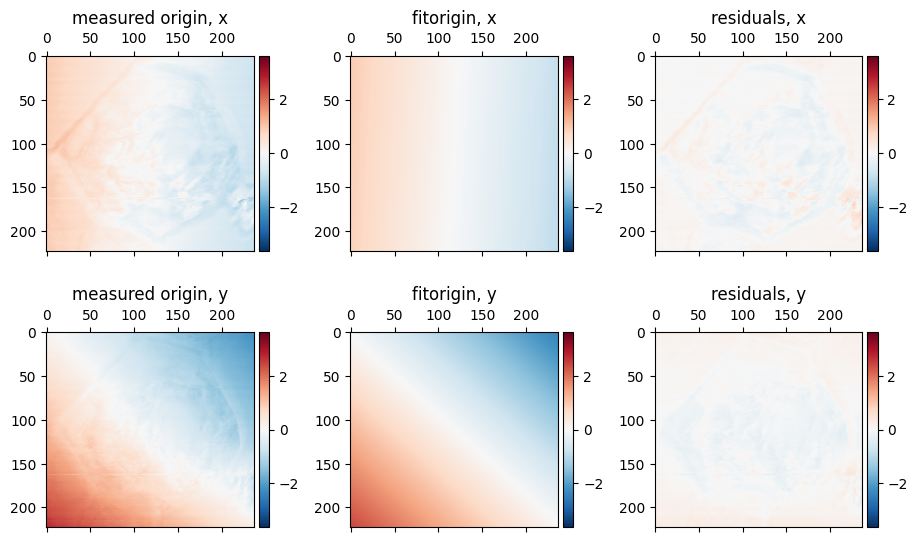

In [9]:
# Compute the origin position for all probe positions.
# This algorithm works by searching for peak pairs (Friedel symmetry) and finding the mean position of these pairs.

qxy_origins = bragg_peaks.measure_origin(
    center_guess = center_guess,
)

# Fit a plane to the origins
qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = bragg_peaks.fit_origin()

In [10]:
# apply the calibration
bragg_peaks.calibration.set_origin((qx0_fit, qy0_fit))
bragg_peaks.calibrate()

# Calculate BVM from centered data
bragg_vector_map_centered = bragg_peaks.get_bvm()
bragg_vector_map_cali = bragg_vector_map_centered

### Check before and after on centering

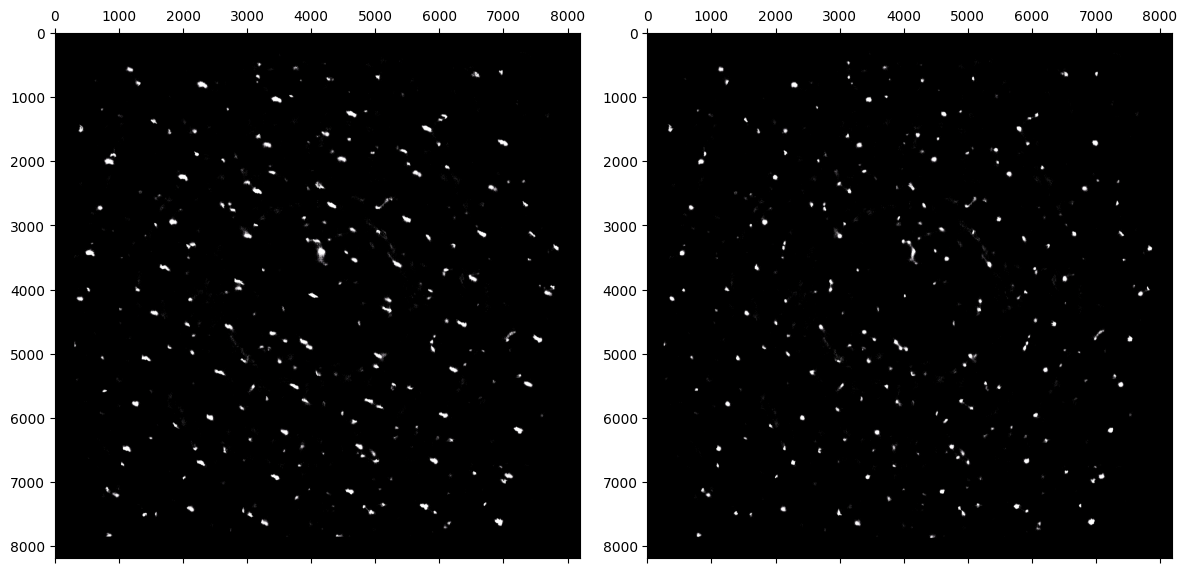

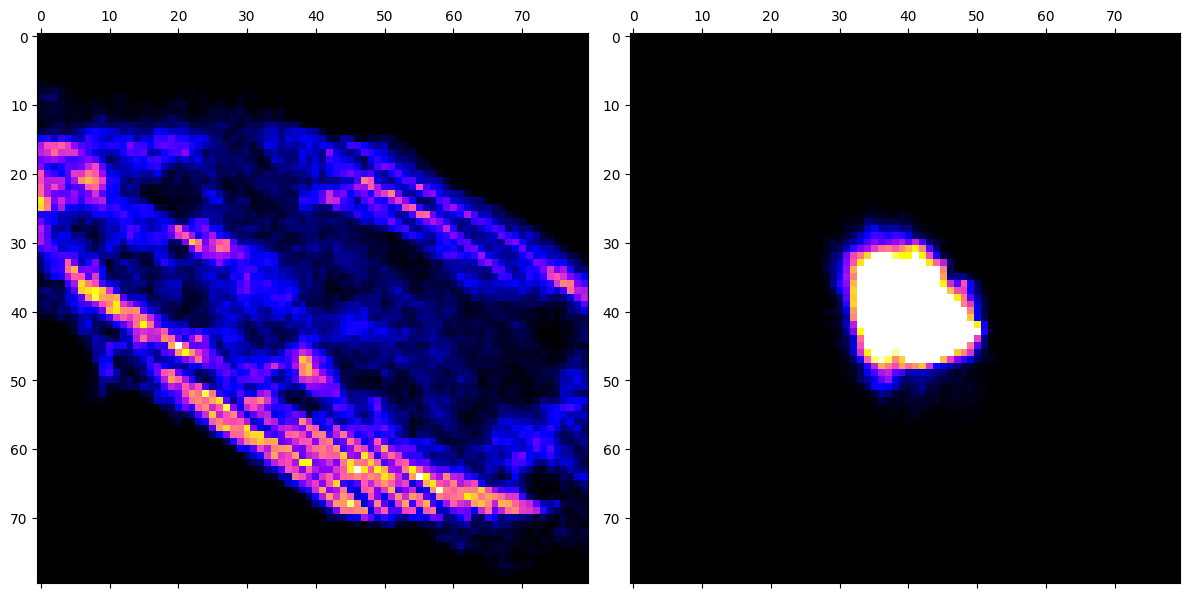

In [11]:
bvm_r = bragg_peaks.histogram( mode='raw', sampling=32 )
bvm_c = bragg_peaks.histogram( mode='cal', sampling=32 )                             
# show
py4DSTEM.show(
    [bvm_r, bvm_c],
    intensity_range='absolute',
    cmap='gnuplot2',
    vmin=0,
    vmax=1
)

# show, zooming in on origin
L = 40
x,y = bvm_c.origin
import numpy as np
x0,xf = np.round([x-L,x+L]).astype(int)
y0,yf = np.round([y-L,y+L]).astype(int)

py4DSTEM.show(
    [
    bvm_r[x0:xf,y0:yf],
    bvm_c[x0:xf,y0:yf]
    ],
    intensity_range='absolute',
    cmap='gnuplot2',
    vmin=0,
    vmax=100000
)



# Rotation Calibration from prior calibration formula
If doing for your own dataset, you'll have to work out your own calibration formula for your detector and your scan rotation.

In [33]:
#Read the appropriate rotation for this dataset
scan_rotation = 0 #rad
calib_rot = scan_rotation - np.radians(51)
#Convert from radians to degrees and print
angle = np.degrees(calib_rot)
angle

np.float64(-51.0)

In [34]:
bragg_peaks.calibration.set_QR_rotation_degrees( angle )
bragg_peaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:          1
             R_pixel_size:          1
             Q_pixel_units:         pixels
             R_pixel_units:         pixels
             QR_flip:               False
             _root_treepath:        /datacube
             probe_semiangle:       4.941633348699613
             qx0_mean:              127.9820663071564
             qy0_mean:              125.69887290742477
             qx0_meas:              2D-array
             qy0_meas:              2D-array
             origin_meas_mask:      2D-array
             qx0:                   2D-array
             qx0_shift:             2D-array
             qy0:                   2D-array
             qy0_shift:             2D-array
             QR_rotation:           -0.8901179185171081
             QR_rotation_degrees:   -51.0
)

# Digital Dark Field

## Convert to Points Array
### This is the slowest bit

In [35]:
pointsarray2 = pointlist_to_array(
    bragg_peaks,
    center=True, # essential to use center correction
    pixel=False, # set true if you wish to work in calibrated units
    ellipse=False, # optional, but doing this is cool in nanocrystalline
    rotate=True, # a good idea if you want to relate real space and crystal directions
    rphi=False # only needed for working in polar coordinates for nanocrystalline
    
)

100%|██████████| 52851/52851 [05:06<00:00, 172.26it/s]


In [36]:
# Sanity check to find out how many diffraction datapoints we have
pointsarray2.shape

(1609908, 5)

In [37]:
bragg_peaks.Qshape

(np.int64(256), np.int64(256))

## BF image
#### Make a rough bright field image for use in navigation

#### Can construct with the standard function

In [39]:
aperturearraycentred0 = aperture_array_generator(
    shape = bragg_peaks.Qshape, # detector shape
    center = (bragg_peaks.Qshape[0]/2,bragg_peaks.Qshape[1]/2), #half the detector size is a good guess
    # center is only important if you want a non-centered array to overlay on 
    # diffraction pattern
    pad = 10, # Excludes anything within 10 pixels of the edge
    mode = 'single', # Just makes one aperture
    g1 = (1,0), # Doesn't matter what this is for just getting a zero
    g2 = (0,1), # Doesn't matter what this is for just getting a zero
    s1 = 0, # Zero lots of g1
    s2 = 0, # Zero lots of g2
    returns = 'centered' # Just the centered array is returned
)

In [40]:
# View the results
aperturearraycentred0

array([[0, 0]])

#### Make the image and display

In [41]:
BF_DDF = DDFimage(
    points_array=pointsarray2, 
    aperture_positions=aperturearraycentred0, 
    tol=2
)

100%|██████████| 1/1 [00:00<00:00, 25.85it/s]


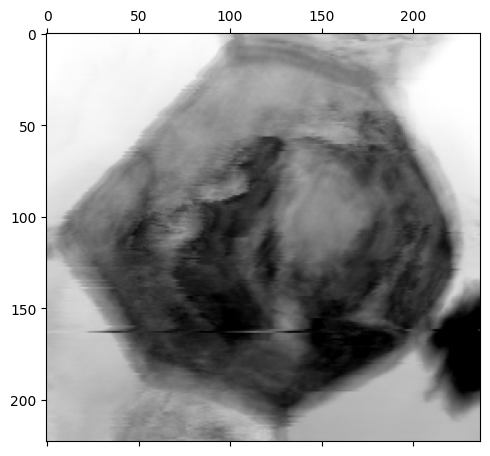

In [42]:
show(BF_DDF)

## DDF using diffraction peak positions from one chosen location

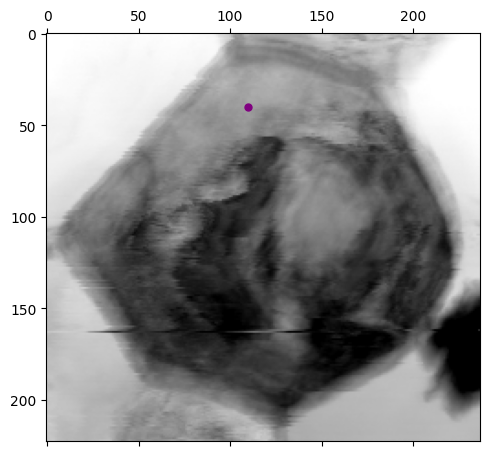

In [76]:
Rx1, Ry1, c1, s = 40,110, 'purple', 10
show(
    BF_DDF,
    points = {
        'x': Rx1,
        'y': Ry1,
        's': s,
        'pointcolor': c1
    }
)

In [44]:
def filter_by_position(pointsarray, Rx, Ry, intensity=False):
    """
    Just finds the peaks at the Rx and Ry positions given

    Parameters
    ----------
    pointsarray: numpy array
        as produced by pointlist_to_array
    Rx, Ry: int
        integers for the selected pixels
    intensity: bool
        whether to report intensity too
    Returns
    ----------
    positionfilteredarray: numpy array
         This will be an 2D numpy array of n points x 2 or 3 columns:
            qx
            qy
            I (if intensity == True)

    """
    positionfilteredarray = pointsarray[
        np.where(
            np.logical_and(
                pointsarray[:,3]==Rx,
                pointsarray[:,4]==Ry
            )
        )
    ]
    if intensity:
        return positionfilteredarray[:,:3]
    else:
        return positionfilteredarray[:,:2]

#### Find the diffraction peak positions at probe position defined

In [45]:
points_pos1 = filter_by_position(pointsarray2, Rx1,Ry1)

In [46]:
# Look at the list
points_pos1

array([[ 6.30409013e-02,  2.19051270e-03],
       [ 3.25393966e+01,  1.76783137e+01],
       [-3.24185960e+01, -1.76017655e+01],
       [ 2.10926444e+01, -3.97386372e+01],
       [ 5.36835322e+01, -2.21053238e+01],
       [ 6.54799123e+01,  3.53823638e+01],
       [-6.46013695e+01, -3.52250914e+01],
       [ 4.18752014e+01, -7.98915375e+01],
       [-1.15035694e+01, -5.74542202e+01],
       [ 8.63583103e+01, -4.78695240e+00],
       [-2.04655722e+01,  4.01021407e+01],
       [ 1.21801216e+01,  5.77431593e+01],
       [-5.28075161e+01,  2.22598453e+01],
       [ 7.43959921e+01, -6.24852755e+01],
       [-4.42054637e+01, -7.50857497e+01],
       [ 1.07213136e+02, -4.53564989e+01],
       [ 9.11350841e+00, -9.74226955e+01],
       [-2.33951263e+01, -1.15150361e+02],
       [ 1.19297225e+02,  1.25450175e+01],
       [-8.51386132e+01,  4.77910464e+00],
       [ 4.51079340e+01,  7.52917149e+01],
       [ 1.39890632e+02, -2.80826409e+01],
       [ 9.89204473e+01,  5.23027612e+01],
       [-9.

The lists are always ordered in decreasing intensity.  The zero item in the list is almost always the primary beam.  So you could just choose the brightest 5 or 10 excluding the primary beam.

In [47]:
Rx1Ry1shortlist = points_pos1[1:11,:2]

In [48]:
Rx1Ry1image = DDFimage(
    points_array=pointsarray2, 
    aperture_positions=Rx1Ry1shortlist, 
    tol=1
)

100%|██████████| 10/10 [00:00<00:00, 26.35it/s]


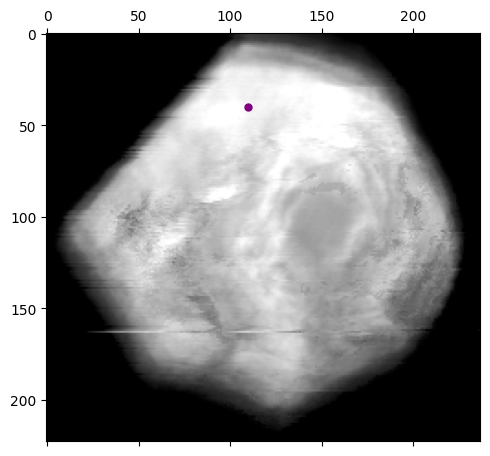

In [49]:
color = "r"
show(
    Rx1Ry1image,
    points = {
        'x': Rx1,
        'y': Ry1,
        's': s,
        'pointcolor': color
    }
)

Seeing as the other crystals present have unrelated orientations, this highlights one crystal very well.  And this can be used for strain analysis.

## Strain mapping
But just for grain of interest

In [50]:
strainmap = py4DSTEM.StrainMap( braggvectors=bragg_peaks )


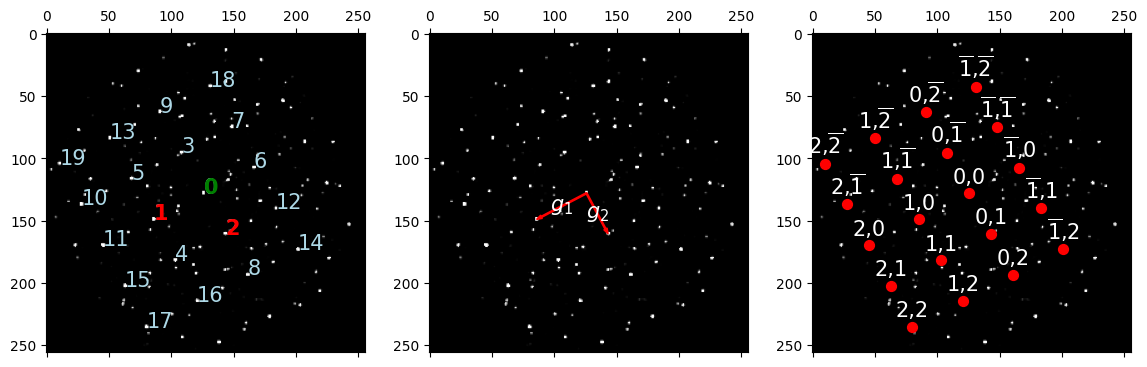

In [52]:
strainmap.choose_basis_vectors(
    minSpacing=4,
    minAbsoluteIntensity=1e6,
    maxNumPeaks=20,
    edgeBoundary=1,
    index_g1=1,
    index_g2=2,
    vis_params = {
        'vmin' : 0,
        'vmax' : 0.995
    }
)

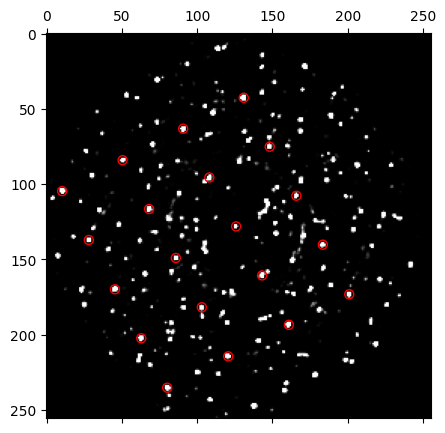

Indexing Bragg scattering: 100%|██████████| 52.9k/52.9k [00:26<00:00, 2.01kDP/s]
Fitting lattice vectors: 100%|██████████| 52.9k/52.9k [00:09<00:00, 5.39kDP/s]


In [55]:
strainmap.fit_basis_vectors(
    max_peak_spacing = 3,
)

Use the DDF image to make a mask

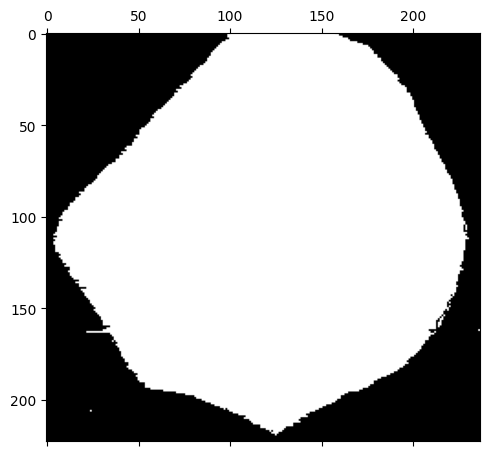

In [58]:
ROI = np.where(Rx1Ry1image>np.percentile(Rx1Ry1image,20),True,False)
show(ROI)

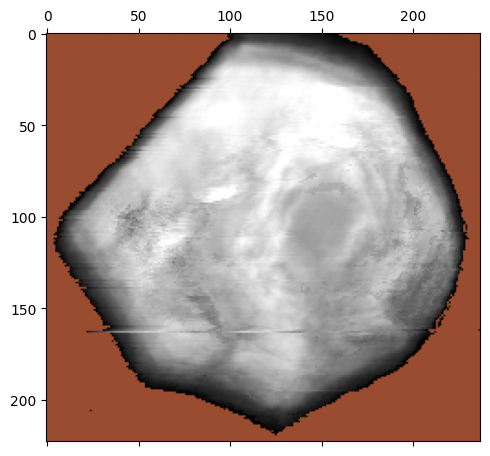

In [93]:
py4DSTEM.show(
    Rx1Ry1image,
    mask = ROI,
    mask_color='coral',
    mask_alpha=0.4
)


Calculating strain: 100%|██████████| 52.9k/52.9k [00:10<00:00, 4.91kDP/s]


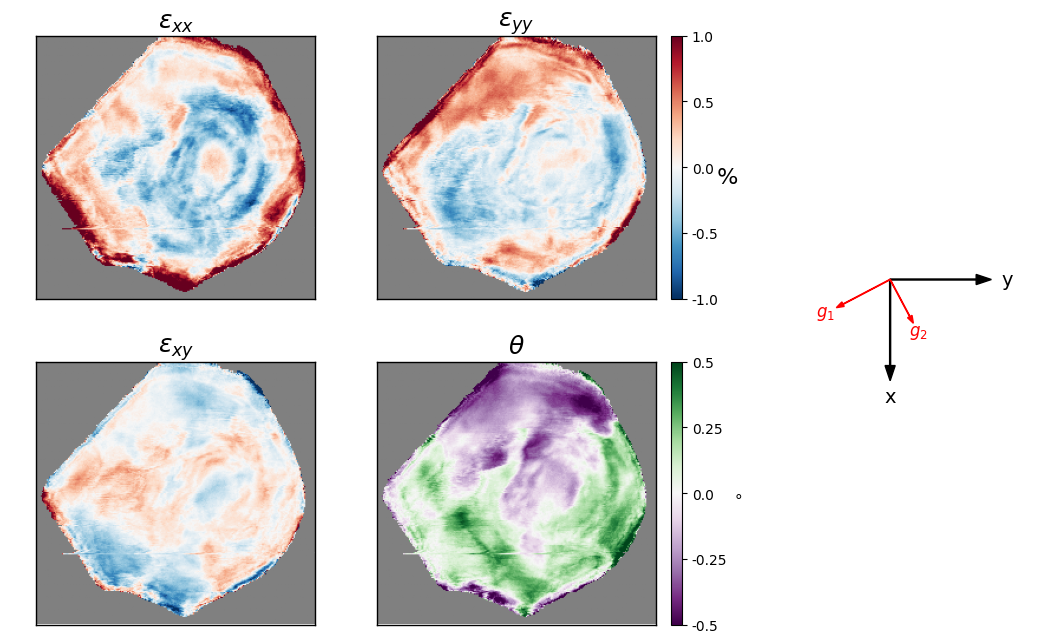

In [64]:
strainmap.get_strain(
    gvects = ROI,
#    coordinate_rotation = 0,
    layout = "square",
    vrange = [-1.0, 1.0],
    vrange_theta = [-0.5, 0.5],
    mask_color = "grey"
)

There's quite a bit of internal strain in this grain.  This is entirely expected.  The ceramic was deliberately cooked in such a way as to give a core-shell structure and chemical segregation.  It actually separates into three layers - inner core, outer core, shell.

## DDF imaging with arrays using the strain vectors

### We need two sensible g vector choices

In [53]:
g1 = np.array(strainmap.g1)
g1

array([ 20.9972109 , -40.10022496])

In [54]:
g2 = np.array(strainmap.g2)
g2

array([32.6026585, 17.3153626])

now we can use these to plot out some possible different arrays of spots to suit this area, which is all containing crystals with some spots in common

### Set up a little plotting function to allow comparison to the crystal spots 

In [65]:
def plot_filtarray_and_apertures(
    filteredarray, 
    aperturearraycentred, 
    c='blue',
    maxax=120,
    iscale=.03,
    ax=None
):
    if ax == None:
        fig,ax = plt.subplots(1,figsize=(6,6))
    else:
        pass
    ax.scatter(
        filteredarray[:,1],
        filteredarray[:,0],
        s=filteredarray[:,2]*iscale,c=c)
    ax.scatter(aperturearraycentred[:,1],aperturearraycentred[:,0],marker='o',ec='k',fc='none'),
    ax.set_ylim(maxax,-maxax)
    ax.set_xlim(-maxax,maxax)

### Choose a first set of apertures and make a DDF image

In [66]:
# Find peaks for this positions
filt1 = filter_by_position(pointsarray2, Rx1, Ry1, intensity=True)
# Need to set intensity = True to get the intensities for the plotting function

In [67]:
aperturearraycentred1 = aperture_array_generator(
    bragg_peaks.Qshape, # diffraction pattern shape
    (127,127), # center position of detector in pixels
    10, # pad to exclude edge spots
    'array', # mode - in this case we are selecting an array
    g1, g2, # the basis vectors
    n1lims=(-3,3), n2lims=(-3,3), 
    s1 = 0, s2 = 0, # The shifts off-centre of the lattice
    r1=5, r2=80, # minimum and maximum radii for spots from centre
    returns='centered' # Just the centered dataset (only need the other 
    # for overlay on actual diffraction patterns)
)

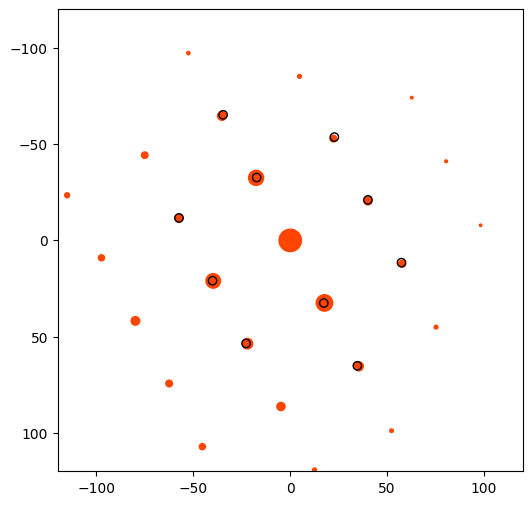

In [68]:
plot_filtarray_and_apertures(
    filt1,
    aperturearraycentred1,
    c='orangered',
    iscale=.1
)

In [69]:
pointslist1image = DDFimage(
    points_array=pointsarray2, 
    aperture_positions=aperturearraycentred1, 
    tol=2
)

100%|██████████| 10/10 [00:00<00:00, 25.57it/s]


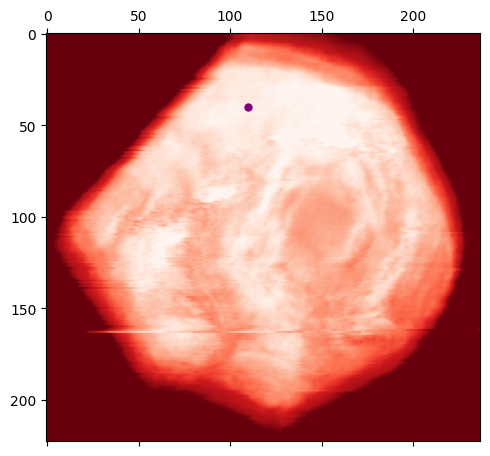

In [77]:
show(
    pointslist1image,
    points = {
        'x': Rx1,
        'y': Ry1,
        's': s,
        'pointcolor': c1
    },
    cmap = 'Reds_r'
)

This shows the obvious result that a DDF image made with peaks for the primitive perovskite structure along this [112] direction highlights the whole grain

### Choose a second set of apertures and make a DDF image

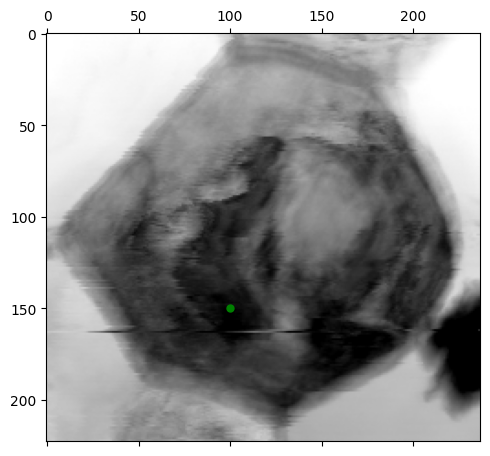

In [80]:
Rx2, Ry2, c2, s = 150,100, 'green', 10
show(
    BF_DDF,
    points = {
        'x': Rx2,
        'y': Ry2,
        's': s,
        'pointcolor': c2
    },
    cmap = 'grey'
)

In [81]:
# Find peaks for this positions
filt2 = filter_by_position(pointsarray2, Rx2, Ry2,intensity=True)

In [86]:
aperturearraycentred2 = aperture_array_generator(
    bragg_peaks.Qshape, # diffraction pattern shape
    (127,127), # center position of detector in pixels
    10, # pad to exclude edge spots
    'array', # mode - in this case we are selecting an array
    g1, g2, # the basis vectors
    n1lims=(-5,5), n2lims=(-5,5), 
    s1 = 1/2, s2 = 0, # The shifts off-centre of the lattice
    r1=5, r2=100, # minimum and maximum radii for spots from centre
    returns='centered' # Just the centered dataset (only need the other 
    # for overlay on actual diffraction patterns)
)

This picks out 1/2 spacing spots along the g2 direction.

These show the 0002 plane direction for the hexagonal alpha titanium laths

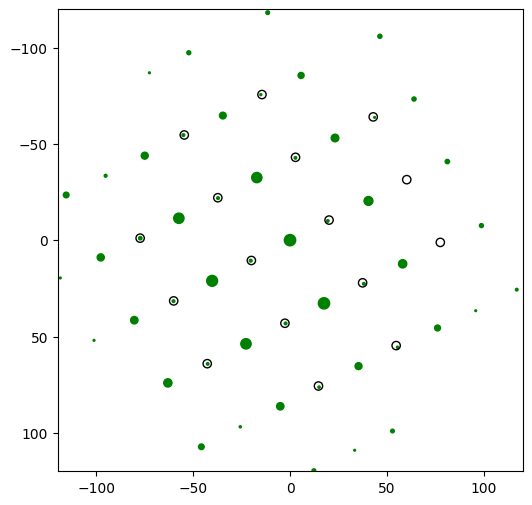

In [87]:
plot_filtarray_and_apertures(
    filt2,
    aperturearraycentred2,
    c='green',
    iscale=.1
)

In [91]:
pointslist2image = DDFimage(
    points_array=pointsarray2, 
    aperture_positions=aperturearraycentred2, 
    tol=2
)

100%|██████████| 16/16 [00:00<00:00, 27.28it/s]


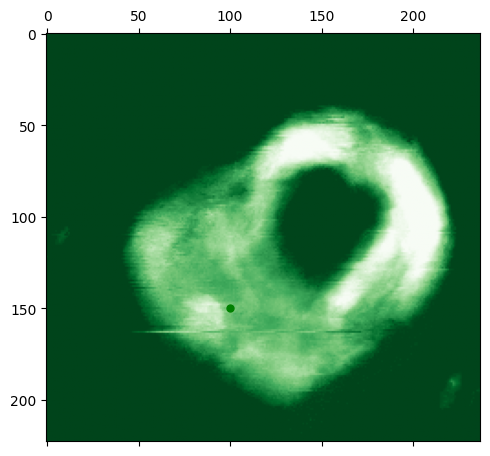

In [92]:
show(
    pointslist2image,
    points = {
        'x': Rx2,
        'y': Ry2,
        's': s,
        'pointcolor': c2
    },
    cmap = 'Greens_r'
)

This shows that if we select peaks shift by half a reciprocal lattice vector along the 111 direction, we only get a polo of intensity.  In the original paper, it is shown that this comes from having BiFeO3-like crystal structure in these regions.